In [2]:
import scanpy as sc
import os
import requests
from tqdm import tqdm
from anndata import AnnData as ad
import pandas as pd
from celldreamer.paths import DATA_DIR
import numpy as np

Read dataset 

In [2]:
def load_dataset(path, url, new_name=None):
    # Check if the file exists at the specified path
    if not os.path.exists(path):
        # If not, download the file from the URL
        print(f"Dataset not found at {path}. Downloading from {url}...")
        response = requests.get(url, stream=True)
        
        # Get the total file size for progress bar
        total_size_in_bytes = int(response.headers.get('content-length', 0))
        block_size = 1024 # 1 Kilobyte

        progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)

        with open(path, 'wb') as f:
            for data in response.iter_content(block_size):
                progress_bar.update(len(data))
                f.write(data)
        progress_bar.close()

        if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
            print("ERROR, something went wrong")
        
        print("Download complete.")
    
    # Rename the dataset file if new_name is provided
    if new_name:
        os.rename(path, new_name)
        path = new_name

    # Load the dataset using Scanpy
    dataset = sc.read_h5ad(path)
    return dataset

dataset_path = os.path.join(DATA_DIR, 'raw', 'hlca_core.h5ad')
dataset_url = 'https://datasets.cellxgene.cziscience.com/7a3f08f9-5d07-4ddd-a8fe-5967dd34f35f.h5ad'

adata = load_dataset(path=dataset_path, url=dataset_url, new_name=dataset_path)

In [3]:
adata.layers["X_counts"] = adata.raw.X.copy()

In [6]:
adata

AnnData object with n_obs × n_vars = 584944 × 27997
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'dataset', 'entropy_dataset_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_subject_ID_leiden_3', 'fresh_or_frozen', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_5', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'n_genes_detected', 'original_ann_highest_res', 'original_ann_level_1', '

In [4]:
sc.pp.filter_genes(adata, min_cells=10)

In [5]:
adata 

AnnData object with n_obs × n_vars = 584944 × 27997
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'dataset', 'entropy_dataset_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_subject_ID_leiden_3', 'fresh_or_frozen', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_5', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'n_genes_detected', 'original_ann_highest_res', 'original_ann_level_1', '

Preprocess

In [8]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pynndescent/pynndescent_.py:346: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/reference/deprecation.html#deprecation-of-old-style-numba-captured-errors
Exception origin:
  File "/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/numba/core/types/functions.py", line 486, in __getnewargs__
    raise ReferenceError("underlying object has vanished")

  init_rp_tree(data, dist, current_graph, leaf_array)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pynndescent/pynndescent_.py:348: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style'

## Train Test split 

In [11]:
# Generate random indices for train and test sets
total_samples = adata.n_obs
train_frac = 0.8
train_size = int(total_samples * train_frac)
train_indices = np.random.choice(total_samples, size=train_size, replace=False)
test_indices = np.setdiff1d(np.arange(total_samples), train_indices)

# Separate data into train and test sets by indexing the Anndata object
train_adata = adata[train_indices, :]
test_adata = adata[test_indices, :]

In [12]:
train_adata

View of AnnData object with n_obs × n_vars = 467955 × 27997
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'dataset', 'entropy_dataset_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_subject_ID_leiden_3', 'fresh_or_frozen', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_5', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'n_genes_detected', 'original_ann_highest_res', 'original_ann_lev

In [13]:
test_adata

View of AnnData object with n_obs × n_vars = 116989 × 27997
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'dataset', 'entropy_dataset_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_subject_ID_leiden_3', 'fresh_or_frozen', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_5', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'n_genes_detected', 'original_ann_highest_res', 'original_ann_lev

In [14]:
adata

AnnData object with n_obs × n_vars = 584944 × 27997
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'dataset', 'entropy_dataset_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_subject_ID_leiden_3', 'fresh_or_frozen', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_5', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'n_genes_detected', 'original_ann_highest_res', 'original_ann_level_1', '

## Save

In [15]:
sc.AnnData.write_h5ad(adata, DATA_DIR / "processed_full_genome" / "hlca_core" / "hlca_core.h5ad")

In [16]:
sc.AnnData.write_h5ad(train_adata, DATA_DIR / "processed_full_genome" / "hlca_core" / "hlca_core_train.h5ad")

In [17]:
sc.AnnData.write_h5ad(test_adata, DATA_DIR / "processed_full_genome" / "hlca_core" / "hlca_core_test.h5ad")

## Run highly variable gene selection

In [9]:
adata = sc.read_h5ad(DATA_DIR / "processed_full_genome" / "hlca_core" / "hlca_core.h5ad")
train_adata = sc.read_h5ad(DATA_DIR / "processed_full_genome" / "hlca_core" / "hlca_core_train.h5ad")
test_adata = sc.read_h5ad(DATA_DIR / "processed_full_genome" / "hlca_core" / "hlca_core_test.h5ad")

In [3]:
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="X_counts",
    subset=False,
)

In [4]:
train_adata.var = adata.var
test_adata.var = adata.var

In [5]:
sc.AnnData.write_h5ad(adata, DATA_DIR / "processed_full_genome" / "hlca_core" / "hlca_core.h5ad")
sc.AnnData.write_h5ad(test_adata, DATA_DIR / "processed_full_genome" / "hlca_core" / "hlca_core_test.h5ad")
sc.AnnData.write_h5ad(train_adata, DATA_DIR / "processed_full_genome" / "hlca_core" / "hlca_core_train.h5ad")

In [10]:
adata

AnnData object with n_obs × n_vars = 584944 × 27997
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'dataset', 'entropy_dataset_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_subject_ID_leiden_3', 'fresh_or_frozen', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_5', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'n_genes_detected', 'original_ann_highest_res', 'original_ann_level_1', '

In [7]:
test_adata

AnnData object with n_obs × n_vars = 116989 × 27997
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'dataset', 'entropy_dataset_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_subject_ID_leiden_3', 'fresh_or_frozen', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_5', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'n_genes_detected', 'original_ann_highest_res', 'original_ann_level_1', '

In [8]:
train_adata

AnnData object with n_obs × n_vars = 467955 × 27997
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'dataset', 'entropy_dataset_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_subject_ID_leiden_3', 'fresh_or_frozen', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_5', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'n_genes_detected', 'original_ann_highest_res', 'original_ann_level_1', '

## Cell type classification

In [5]:
adata = sc.read_h5ad(DATA_DIR / "processed_full_genome" / "hlca_core" / "hlca_core.h5ad")

In [8]:
adata.obs.columns

Index(['suspension_type', 'donor_id', 'is_primary_data',
       'assay_ontology_term_id', 'cell_type_ontology_term_id',
       'development_stage_ontology_term_id', 'disease_ontology_term_id',
       'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id',
       'organism_ontology_term_id', 'sex_ontology_term_id', 'BMI',
       'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score',
       'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1',
       'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5',
       'cause_of_death', 'dataset', 'entropy_dataset_leiden_3',
       'entropy_original_ann_level_1_leiden_3',
       'entropy_original_ann_level_2_clean_leiden_3',
       'entropy_original_ann_level_3_clean_leiden_3',
       'entropy_subject_ID_leiden_3', 'fresh_or_frozen', 'leiden_1',
       'leiden_2', 'leiden_3', 'leiden_4', 'leiden_5', 'log10_total_counts',
       'lung_condition', 'mixed_ancestry', 'n_genes_detected',
       'o

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


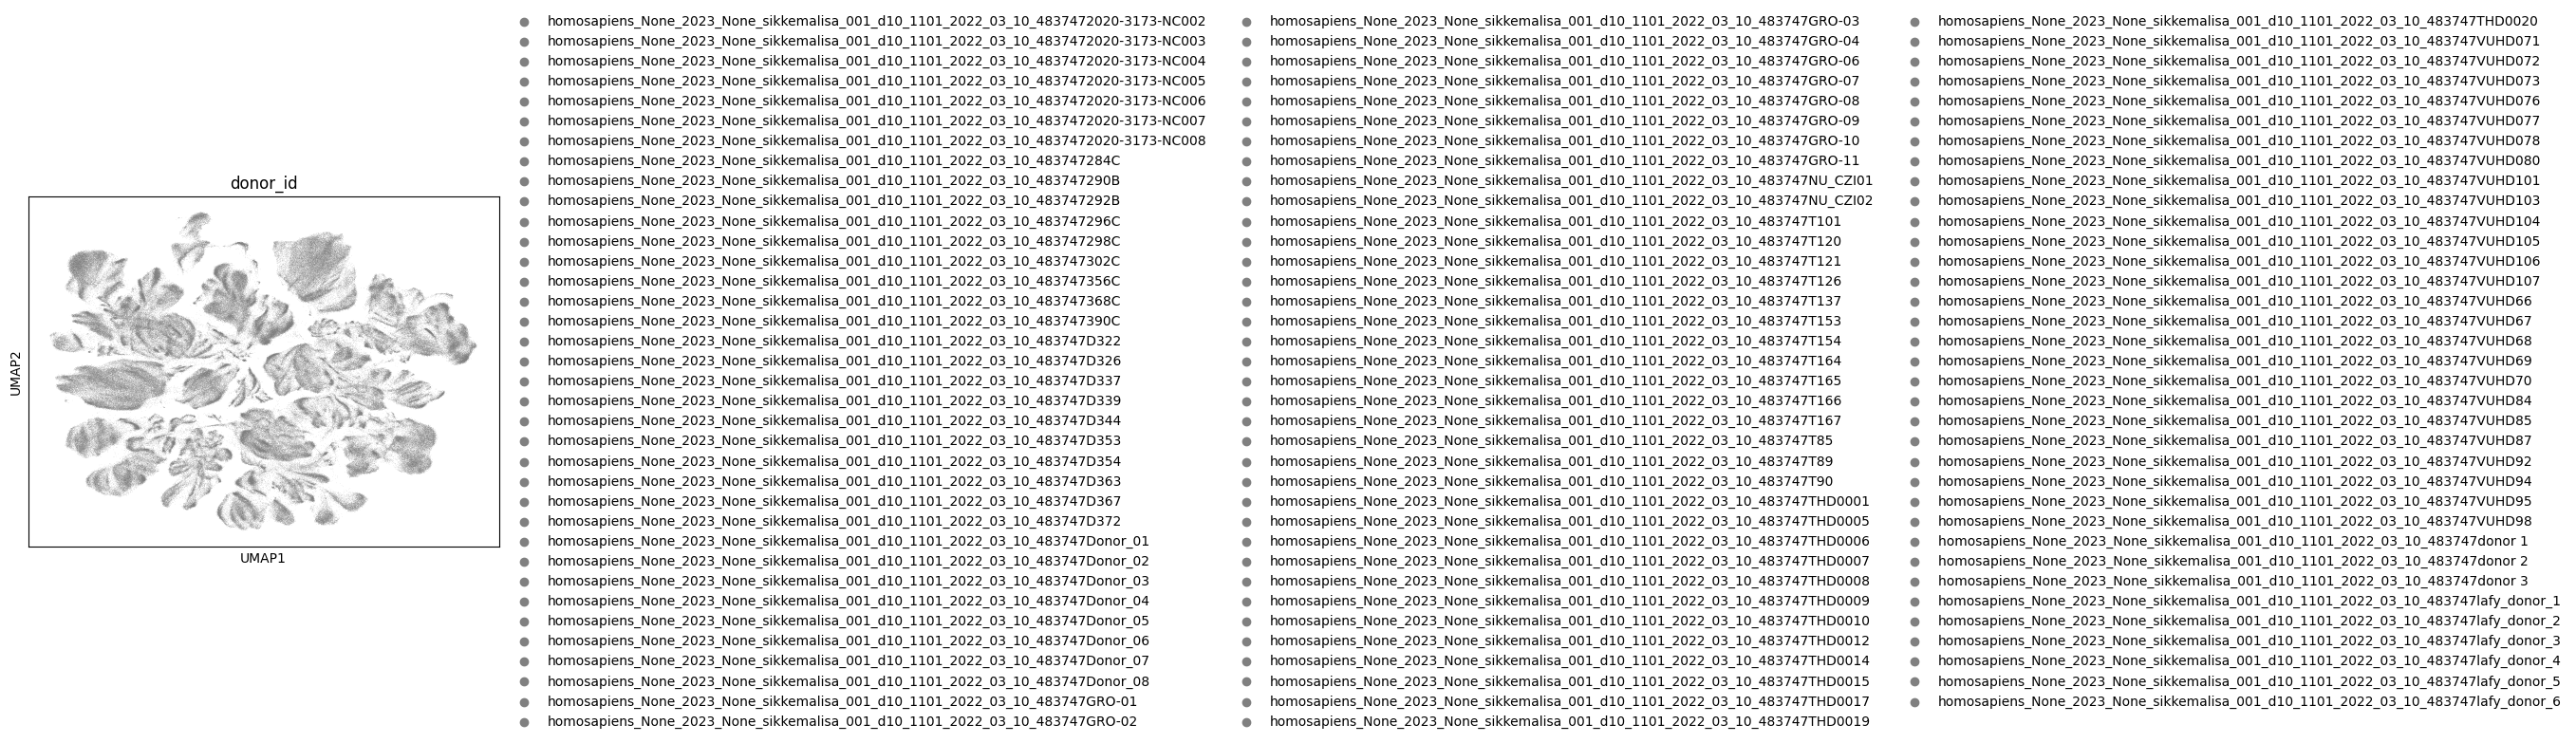

In [18]:
sc.pl.umap(adata,color="donor_id")

In [21]:
# Define the number of donors for training and test sets
donors_for_training = 80
donors_for_test = 27

# Get unique donor IDs
unique_donors = adata.obs['donor_id'].unique()

# Set numpy seed for reproducibility
np.random.seed(10)

# Randomly select donors for training and test sets
train_donors = np.random.choice(unique_donors, size=donors_for_training, replace=False)
test_donors = np.setdiff1d(unique_donors, train_donors)

# Get indices for samples belonging to selected donors
train_indices_full = adata.obs.index[adata.obs['donor_id'].isin(train_donors)]
test_indices_full = adata.obs.index[adata.obs['donor_id'].isin(test_donors)]

# Create train and test sets
adata_train = adata[train_indices_full]
adata_test = adata[test_indices_full]

# Print statistics
print("Statistics:")
print("Number of samples in train set:", len(adata_train), f'{len(adata_train) / (len(adata_train) + len(adata_test)):.2%}')
print("Number of samples in test set:", len(adata_test), f'{len(adata_test) / (len(adata_train) + len(adata_test)):.2%}')
print("Number of donors in train set:", len(train_donors))
print("Number of donors in test set:", len(test_donors))
print("Number of unique cell types in train set:", len(adata_train.obs['cell_type'].unique()))
print("Number of unique cell types in test set:", len(adata_test.obs['cell_type'].unique()))

Statistics:
Number of samples in train set: 429918 73.50%
Number of samples in test set: 155026 26.50%
Number of donors in train set: 80
Number of donors in test set: 27
Number of unique cell types in train set: 50
Number of unique cell types in test set: 50


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


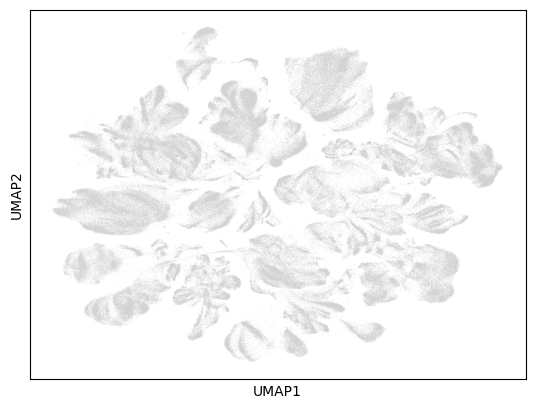

In [24]:
sc.pl.umap(adata_train)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


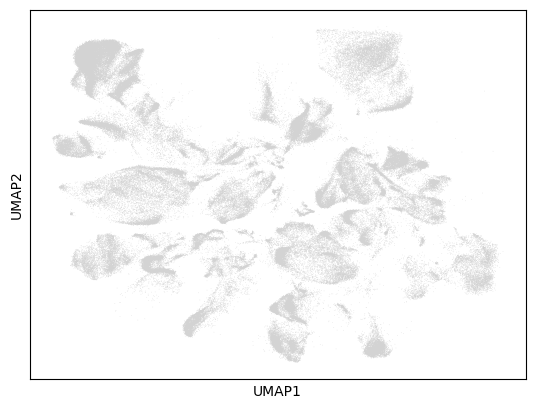

In [25]:
sc.pl.umap(adata_test)

In [26]:
adata_train = adata_train[:, adata_train.var.highly_variable]

In [27]:
adata_test = adata_test[:, adata_test.var.highly_variable]

In [31]:
adata_train.write_h5ad("/home/icb/alessandro.palma/environment/celldreamer/project_folder/datasets/processed/classifier_experiment_hlca/hlca_train.h5ad")

In [32]:
adata_test.write_h5ad("/home/icb/alessandro.palma/environment/celldreamer/project_folder/datasets/processed/classifier_experiment_hlca/hlca_test.h5ad")

In [3]:
adata = sc.read_h5ad(DATA_DIR / "processed_full_genome" / "hlca_core" / "hlca_core.h5ad")

In [4]:
adata

AnnData object with n_obs × n_vars = 584944 × 27997
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'dataset', 'entropy_dataset_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_subject_ID_leiden_3', 'fresh_or_frozen', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_5', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'n_genes_detected', 'original_ann_highest_res', 'original_ann_level_1', '

In [6]:
adata.obs.cell_type

GCGACCATCCCTAACC_SC22                       alveolar macrophage
P2_1_GCGCAACCAGTTAACC                       natural killer cell
GCTCTGTAGTGCTGCC_SC27                        type II pneumocyte
P2_8_TTAGGACGTTCAGGCC                       alveolar macrophage
CTTGATTGTCAGTTTG_T164                    respiratory basal cell
                                           ...                 
ACCTTTACATTAACCG_T120                    respiratory basal cell
CATTATCTCCATGAAC_F01639    CD1c-positive myeloid dendritic cell
AGGCCGTGTGTGACCC-SC56                        type II pneumocyte
CGATGGCAGCAGGCTA-1-2                                  club cell
AATCGGTGTCGGCACT-1-4                                  club cell
Name: cell_type, Length: 584944, dtype: category
Categories (50, object): ['hematopoietic stem cell', 'fibroblast', 'mesothelial cell', 'T cell', ..., 'bronchus fibroblast of lung', 'alveolar type 1 fibroblast cell', 'alveolar type 2 fibroblast cell', 'respiratory hillock cell']